In [1]:
import qiskit
from qiskit_aer import AerSimulator
# from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt

In [2]:
def kinetic_Step(dt,n):
    x = qiskit.QuantumRegister(n,'x')
    qc = qiskit.QuantumCircuit(x)
    N = 2**n
    dp = 2*pi/N
    b = pi*dp/n
    c = dp**2
    for j in range(n):
        qc.p(n*dt*b*2**(n-1-j),j)

    for j in range(n):
        for l in range(0,n):
            if j!=l:
                qc.cp(-dt/2*c*2**(2*n-2-j-l),l,j)
            else:
                qc.p(-c*dt/2*2**(2*n-2-j-l),j)
    return qc.to_gate()

def harmonic_Pot_Step(dt,n,L,omega=1):
    x = qiskit.QuantumRegister(n,'x')
    qc = qiskit.QuantumCircuit(x)
    dx = L/(2**n)
    b = L/2*dx/n
    c = dx**2
    for j in range(n):
        qc.p(n*omega**2*dt*b*2**(n-1-j),j)

    for j in range(n):
        for l in range(0,n):
            if j!=l:
                qc.cp(-dt/2*omega**2*c*2**(2*n-2-j-l),l,j)
            else:
                qc.p(-c*omega**2*dt/2*2**(2*n-2-j-l),j)
    return qc.to_gate()


In [3]:
def getDeltaCircuit(n, intitalCondition):
    qc = qiskit.QuantumCircuit(qiskit.QuantumRegister(n,'x'))
    for i in range(n):
        if (intitalCondition & (1 << i)):
            qc.x(qc.qubits[i])

    return qc

In [4]:
# constructing th ecircuit:

sim = AerSimulator(method='statevector')



**a)**  For the Free particle the the Hamiltonian $\mathcal{H} = \frac{p^2}{2m}+V(x)$ simplifies to $\mathcal{H}_\textrm{free} = \frac{p^2}{2m}$, thus the  first order Suzuki-Trotter approximation is just $\exp{\left(i\frac{p^2}{2m}\delta t\right)}$. For simplicity $m=1$ is assumed.

In [5]:
n = 8
dt = 1
initialConditon = 2**n//2
L=2



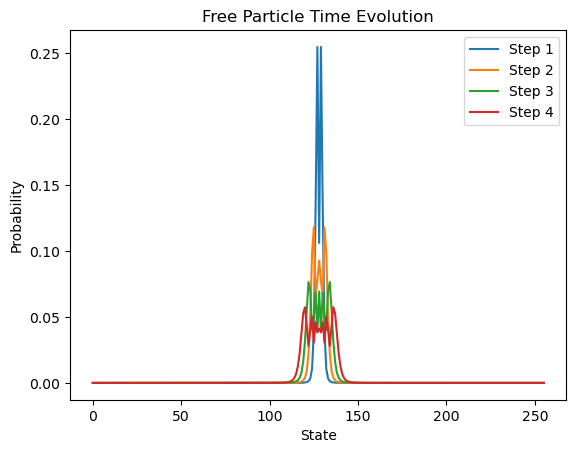

In [6]:
def free_particle_sim(num_steps,dt,n,initialConditon):
    step = kinetic_Step(dt,n)
    for i in range(num_steps):
        qc = getDeltaCircuit(n,initialConditon)
        qc.append(QFT(n,do_swaps=False),qc.qubits[:])
        for j in range(i):
            qc.append(step,qc.qubits[:])
        qc.append(QFT(n, inverse=True,do_swaps=False),qc.qubits[:])

        #sim of curcuit
        qc.save_statevector()
        if i!=0:
            statevec =np.abs( sim.run(qiskit.transpile(qc, sim),shots=1000).result().get_statevector(qc))**2
            plt.plot(statevec,label = f'Step {i}')

    plt.xlabel("State") # plotting the states in decimal numbered states
    plt.ylabel("Probability")
    plt.title("Free Particle Time Evolution")
    plt.legend()
    plt.show()
free_particle_sim(5,dt,n,initialConditon)

**c)** For the Harmonic Oscillator the Potential reads $V(x) =  \frac{1}{2}m\omega^2x^2$, therefore the  first order Suzuki-Trotter approximation reads $\exp{\left(i\frac{p^2}{2m}\delta t\right)} \exp{\left ( i\delta t V(x) \right)}$

In [13]:
def getPsi0(L,n):
    x = np.linspace(-L/2, L/2, 2**n)
    psi0 =(1/np.pi)**(1/4)*np.exp(-1/2*x**2)
    return psi0/np.linalg.norm(psi0)
def getCircuit(n,L):
    initialConditon=getPsi0(L,n)
    qc = qiskit.QuantumCircuit(qiskit.QuantumRegister(n,'x'))
    qc.initialize(initialConditon)
    return qc

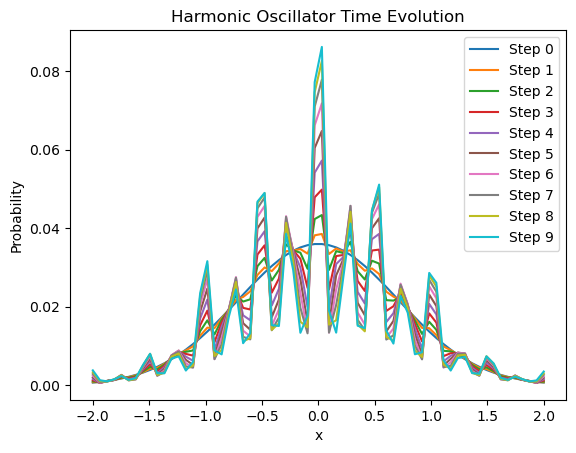

In [60]:
def ham_osci_sim(num_steps,dt,n,L,getCircuit,omega=1):
    step = kinetic_Step(dt,n)
    pot_Step = harmonic_Pot_Step(dt,n,L,omega)
    for i in range(*num_steps):
        qc = getCircuit(n,L)
        for _ in range(i):
            qc.append(pot_Step,qc.qubits[:])
            qc.append(QFT(n,do_swaps=False),qc.qubits[:])
            qc.append(step,qc.qubits[:])
            qc.append(QFT(n, inverse=True,do_swaps=False),qc.qubits[:])

        #sim of curcuit
        qc.save_statevector()
        # if i!=0:
        statevec =np.abs( sim.run(qiskit.transpile(qc, sim),shots=1000).result().get_statevector(qc))**2
        plt.plot(np.linspace(-L/2, L/2, 2**n),statevec,label = f'Step {i}')

    plt.xlabel("x") # plotting the states in decimal numbered states
    plt.ylabel("Probability")
    plt.title("Harmonic Oscillator Time Evolution")
    plt.legend()
    plt.show()
ham_osci_sim((0,10),0.1,6,4,getCircuit)